In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA
from pandas import concat


# Data Import and Cleaning

In [2]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [3]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [5]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [6]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

In [7]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

# Random Forest

In [12]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [21]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

### Walk-forward validation

In [8]:
# walk-forward validation for univariate data
def rf_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = random_forest_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

In [14]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)


In [15]:
X

array([[-37.51931788],
       [-28.69009585],
       [-29.68807862],
       [-25.6304334 ],
       [-29.07379398],
       [-24.93642602],
       [-35.26209517],
       [-28.06563229],
       [-27.35874871],
       [-28.21685813],
       [-29.18520815],
       [-32.36064526],
       [-20.27214677],
       [-18.80845203],
       [-35.43666563],
       [-23.58340467],
       [-23.06625847],
       [-22.99784234],
       [-31.41962306],
       [-25.46027349],
       [-23.68194297],
       [-21.47771259],
       [-27.02904785],
       [-24.82276444],
       [-23.25520954],
       [-25.32197924],
       [-22.30413021],
       [-23.38024324],
       [-25.17015002],
       [-20.85821571],
       [-23.60348981],
       [-24.86044273],
       [-23.64540855],
       [-25.72826243],
       [-20.17778383],
       [-26.36851112],
       [-21.90534062],
       [-23.64226891],
       [-25.04513087],
       [-24.65590187],
       [-21.77319638],
       [-24.9461431 ],
       [-23.90837982],
       [-25

In [18]:
rf_data = series_to_supervised(X, n_in=4)

>expected=7.5, predicted=14.8
>expected=7.8, predicted=8.3
>expected=3.5, predicted=10.5
>expected=3.9, predicted=7.2
>expected=6.8, predicted=6.5
>expected=2.1, predicted=6.6
MAE: 3.828
ME: 3.730
RMSE: 4.735
Direction Accuracy: 0.000


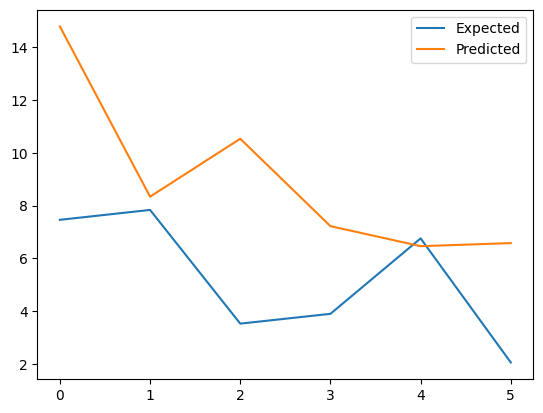

In [24]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_walk_forward_validation(rf_data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

### Static forecast for Random Forest (should be ROLLING WINDOW)

In [25]:
# fit an random forest model and make a one step prediction
# def random_forest_static_forecast(train, testX):
 # transform list into array
train = asarray(train)
 # split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
model_rf_static = RandomForestRegressor(n_estimators=1000)
model_rf_static.fit(trainX, trainy)
 # make a one-step prediction

NameError: name 'train' is not defined

In [177]:
# 
def rf_staticforecast(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = model_rf_static.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [178]:
rf_static_data = series_to_supervised(X, n_in=4)

>expected=7.5, predicted=15.6
>expected=7.8, predicted=8.3
>expected=3.5, predicted=11.5
>expected=3.9, predicted=7.0
>expected=6.8, predicted=6.7
>expected=2.1, predicted=5.3
Forecast accuracy for Static Forecast with Random Forest
ME: 3.811
RMSE: 5.001
Direction Accuracy: 0.200


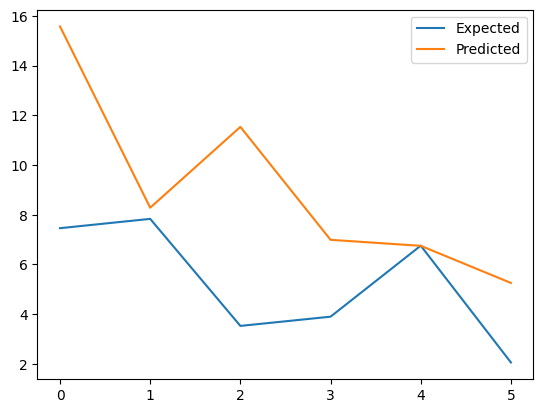

In [179]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_staticforecast(rf_static_data, 6)
#print('MAE: %.3f' % mae)
print('Forecast accuracy for Static Forecast with Random Forest')
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

Can recommend models based on what is needed - metrics or accuracy. 

## Decision Tree

In [304]:
from sklearn.tree import DecisionTreeRegressor

In [305]:
n_lags = 4

In [306]:
y_train = df_train['wPreis'].values


In [183]:
y_train

array([-37.51931788, -28.69009585, -29.68807862, -25.6304334 ,
       -29.07379398, -24.93642602, -35.26209517, -28.06563229,
       -27.35874871, -28.21685813, -29.18520815, -32.36064526,
       -20.27214677, -18.80845203, -35.43666563, -23.58340467,
       -23.06625847, -22.99784234, -31.41962306, -25.46027349,
       -23.68194297, -21.47771259, -27.02904785, -24.82276444,
       -23.25520954, -25.32197924, -22.30413021, -23.38024324,
       -25.17015002, -20.85821571, -23.60348981, -24.86044273,
       -23.64540855, -25.72826243, -20.17778383, -26.36851112,
       -21.90534062, -23.64226891, -25.04513087, -24.65590187,
       -21.77319638, -24.9461431 , -23.90837982, -25.23754357,
       -19.73324755, -24.54094226, -24.73818078, -22.97021231,
       -19.21154856, -16.66741517, -26.54786465, -22.45099313,
       -22.93310518, -23.38212367, -23.28028169, -26.65816299,
       -22.07703349, -17.78619097, -18.98931101,  -7.41127285,
        -6.21131882,  -1.98035287,   1.61215148,   0.48

In [307]:
df_y_train = pd.DataFrame(y_train)


In [185]:
shifted_dfs = [df_y_train.shift(t) for t in range(1, n_lags)]
shifted_dfs

[             0
 0          NaN
 1   -37.519318
 2   -28.690096
 3   -29.688079
 4   -25.630433
 ..         ...
 143  25.673098
 144  22.501691
 145  18.514178
 146  28.985554
 147  16.847234
 
 [148 rows x 1 columns],
              0
 0          NaN
 1          NaN
 2   -37.519318
 3   -28.690096
 4   -29.688079
 ..         ...
 143  27.248645
 144  25.673098
 145  22.501691
 146  18.514178
 147  28.985554
 
 [148 rows x 1 columns],
              0
 0          NaN
 1          NaN
 2          NaN
 3   -37.519318
 4   -28.690096
 ..         ...
 143  34.003188
 144  27.248645
 145  25.673098
 146  22.501691
 147  18.514178
 
 [148 rows x 1 columns]]

In [186]:
for df in shifted_dfs:
    print(df.shape)

(148, 1)
(148, 1)
(148, 1)


In [308]:
concatenated_df = pd.concat(shifted_dfs, axis=1)


In [309]:
diff_df = concatenated_df.diff()
diff_df

,0,0,0
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,8.829222,NaN,NaN
3,-0.997983,8.829222,NaN
4,4.057645,-0.997983,8.829222
...,...,...,...
143,-1.575547,-6.754543,-0.469350
144,-3.171408,-1.575547,-6.754543
145,-3.987512,-3.171408,-1.575547
146,10.471376,-3.987512,-3.171408


In [310]:
diff_values = diff_df.values

# Step 6: Slice the numpy array to exclude the first n_lags rows
sliced_values = diff_values[n_lags:, :]
sliced_values

array([[ 4.05764522e+00, -9.97982775e-01,  8.82922203e+00],
       [-3.44336058e+00,  4.05764522e+00, -9.97982775e-01],
       [ 4.13736796e+00, -3.44336058e+00,  4.05764522e+00],
       [-1.03256692e+01,  4.13736796e+00, -3.44336058e+00],
       [ 7.19646288e+00, -1.03256692e+01,  4.13736796e+00],
       [ 7.06883583e-01,  7.19646288e+00, -1.03256692e+01],
       [-8.58109420e-01,  7.06883583e-01,  7.19646288e+00],
       [-9.68350023e-01, -8.58109420e-01,  7.06883583e-01],
       [-3.17543711e+00, -9.68350023e-01, -8.58109420e-01],
       [ 1.20884985e+01, -3.17543711e+00, -9.68350023e-01],
       [ 1.46369474e+00,  1.20884985e+01, -3.17543711e+00],
       [-1.66282136e+01,  1.46369474e+00,  1.20884985e+01],
       [ 1.18532610e+01, -1.66282136e+01,  1.46369474e+00],
       [ 5.17146191e-01,  1.18532610e+01, -1.66282136e+01],
       [ 6.84161372e-02,  5.17146191e-01,  1.18532610e+01],
       [-8.42178072e+00,  6.84161372e-02,  5.17146191e-01],
       [ 5.95934957e+00, -8.42178072e+00

In [191]:
for t in range(1,n_lags):
    test = pd.DataFrame(y_train).shift(t)

In [311]:
X_train_shift = pd.concat([pd.DataFrame(y_train).shift(t) for t in range(1,n_lags)],1).diff().values[n_lags:,:]
y_train_shift = np.diff(y_train)[n_lags-1:]

In [314]:
y_test = df_test['wPreis'].values


In [315]:
tree = DecisionTreeRegressor(max_depth = 2)
tree.fit(X_train_shift, y_train_shift)


DecisionTreeRegressor(max_depth=2)

In [318]:
y_pred_train = tree.predict(X_train_shift).reshape(-1)

In [319]:
Xt = np.concatenate([X_train_shift[-1,1:].reshape(1,-1),np.array(y_train_shift[-1]).reshape(1,1)],1)


In [320]:
predictions_test = []
for t in range(len(y_test)):
    pred = tree.predict(Xt)
    predictions_test.append(pred[0])
    Xt = np.concatenate([np.array(pred).reshape(1,1),Xt[-1,1:].reshape(1,-1)],1)

In [321]:
y_pred_test = np.array(predictions_test)
y_pred_train = y_train[n_lags-2]+np.cumsum(y_pred_train)
y_pred_test = y_train[-1]+np.cumsum(y_pred_test)

In [322]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(y_pred_test, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Decision Tree Forecast Accuracy of: wPreis
me     :  0.3503
rmse   :  3.6113
direction_accuracy :  0.6
